<a href="https://colab.research.google.com/github/hmanhduc2k/CS4243-Mini-Project/blob/main/CS4243_MiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/abcdefgh # Your team's github repo

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/Colab Notebooks/cs5242-data
# !ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/cs5242-data
models	sample_submission.csv  test_image  train_image	train_label.csv


In [1]:
import pandas as pd
from sklearn.metrics import classification_report

import torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn

from PIL import Image

torch.manual_seed(42)

import torch.optim as optim

# **Do data visualization, data preparation here**

---



In [ ]:
train_df = pd.read_csv("train_label.csv")
print(train_df, len(train_df) )

        ID  Label
0        0      1
1        1      0
2        2      1
3        3      1
4        4      1
...    ...    ...
1159  1159      2
1160  1160      0
1161  1161      2
1162  1162      1
1163  1163      1

[1164 rows x 2 columns] 1164


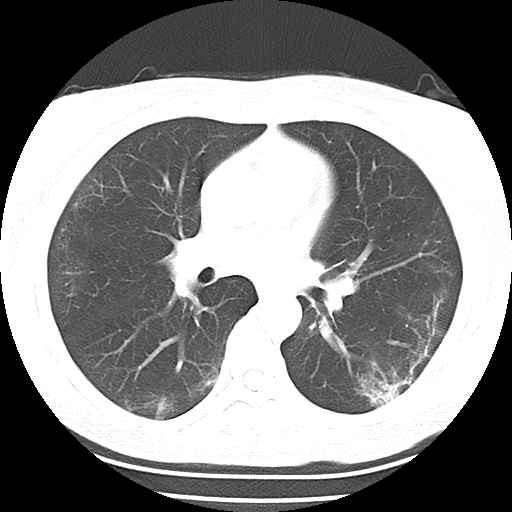

In [ ]:
root = "/content/drive/My Drive/Colab Notebooks/cs5242-data/train_image/train_image/"
img_path = train_df['ID'][0]

img = Image.open(root + str(img_path) + '.png' ) #similar to cv2.imread()
img

# **Write your custom dataloader**

---

In [ ]:
class CS5242_dataset(Dataset): 
    
    def __init__(self, root_path , dataframe, transform=None):
        
        self.df = dataframe    
        self.transform = transform
        self.root_path = root_path
        
        self.image_paths = self.df['ID'] #image names
        self.labels = self.df['Label']
                

    def __getitem__(self, index):
        
        img_path = self.image_paths[index] 
        image = Image.open(self.root_path + str(img_path) + '.png')
        
        target = torch.tensor(self.labels[index])
      
        if self.transform != None:
            image = self.transform(image)
          
        return [image, target]
       
    def __len__(self):
        return len(self.df)

In [ ]:
batch_size = 256
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transformations = transforms.Compose([
                transforms.Resize(size=(224,224),interpolation=2),
                transforms.ToTensor(), #3*H*W, [0, 1]
                normalize]) # normalize with mean/std


train_dataset = CS5242_dataset(root, train_df, transform = transformations)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=2, shuffle = True, pin_memory=True)
train_dataset.__getitem__(0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


[tensor([[[-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          ...,
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],
 
         [[-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          ...,
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],
 
         [[-1.7870, -1.7870, -1.7870,  ..., -1.7870, -1.7870, -1.7870],
          [-1.8044, -1.8044,

# **Write network and training loop**

---


In [ ]:
class Network(nn.Module):
    def __init__(self, pretrained = True, num_classes = 3, drop_rate = 0):
        super(Network, self).__init__()
        resnet = models.resnet18(pretrained) #https://pytorch.org/vision/0.8/models.html
        
        self.features = nn.Sequential(*list(resnet.children())[:-1]) # after avgpool 512x1

        fc_in_dim = list(resnet.children())[-1].in_features # original fc layer's in dimention 512
        self.fc = nn.Linear(fc_in_dim, num_classes) # new fc layer 512x8

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return F.softmax(x, dim=1) #classification output

In [ ]:
model = Network() #instantiate
model.to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Network(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()

num_correct = 0
num_samples = 0

model.train() #set model in training mode # if testing model, use model.eval()
for epoch in range(num_epochs):
    for (x, y) in train_loader:
      
        x = x.to("cuda") #images
        y = y.to("cuda") #unpacks labels

        preds = model(x) #forward pass

        loss = criterion(preds, y)

        optimizer.zero_grad() # backward
        loss.backward()
        optimizer.step() # gradient descent or adam step

        num_correct += torch.sum(torch.eq(preds.argmax(1), y)).item()
        num_samples += preds.size(0)



    train_accuracy = num_correct/num_samples
    print(epoch, train_accuracy)

    

0 0.8032646048109966
1 0.8487972508591065


KeyboardInterrupt: ignored

In [ ]:
preds.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

Exploit temporal information

In [ ]:
def load_transform(image_size=256, crop_size=224):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.Resize(image_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.5),
        # AddGaussianNoise(0., 0.001),
        transforms.Normalize(mean=mean, std=std)
    ])

    valid_transform = transforms.Compose([
        transforms.Resize(size=(image_size, image_size), interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    return train_transform, valid_transform
